## Setup

In [2]:
import pandas as pd
import numpy as np 
import re
from jupyterthemes import jtplot
jtplot.style()

In [3]:
# load raw data
df = pd.read_csv('nuforc_reports.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141261 entries, 0 to 141260
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   summary         141189 non-null  object 
 1   country         140944 non-null  object 
 2   city            140783 non-null  object 
 3   state           131681 non-null  object 
 4   date_time       138601 non-null  object 
 5   shape           134962 non-null  object 
 6   duration        133645 non-null  object 
 7   stats           141261 non-null  object 
 8   report_link     141261 non-null  object 
 9   text            141227 non-null  object 
 10  posted          138601 non-null  object 
 11  city_latitude   115440 non-null  float64
 12  city_longitude  115440 non-null  float64
dtypes: float64(2), object(11)
memory usage: 14.0+ MB


In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if type(text) != str:
        text = 'none'
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()

    # Remove stop words and lemmatize
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(text)

def generate_text_features(df):
    df['cleaned_text'] = df['text'].apply(clean_text)
    df['cleaned_summary'] = df['summary'].apply(clean_text)
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Connor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Connor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Connor\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
feature_df = generate_text_features(df)

In [6]:
# remove empty summaries
feature_df = feature_df.dropna(subset='summary')

## LDA

In [7]:
from sklearn.decomposition import LatentDirichletAllocation, FastICA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import tomotopy as tp
import tqdm 
    

#### Use subset for tuning

In [8]:
# drop some entries without locations
def get_sample(df, n):
    return df.dropna(subset='city_latitude').dropna(subset='summary').sample(n).copy()

In [100]:
sample_df = get_sample(feature_df, 5000)
X_train = pd.merge(sample_df, embeddings, how='inner', left_index=True, right_index=True)
X_train = np.array(list(X_train.bert_embs))

In [101]:
X_train.shape

(4995, 768)

In [105]:
# dbscan hyperparameters
eps = Real(0.001, 100, prior='log-uniform', name='eps')
min_samples = Integer(1, 1000, name='min_samples', prior='log-uniform')
space = [eps, min_samples]

@use_named_args(space)
def tune_dbscan_sil(**params):
    dbscan = DBSCAN(**params)
    clusters = dbscan.fit_predict(X_train)
    if len(set(clusters)) == 1:
        score = 0.0
    else:
        score = silhouette_score(X_train, clusters)
    # minimise - so return negative
    return -score

def extract_kw_params(params, kw='tfidf'):
    keys_to_extract = []
    for k in params.keys():
        if k.startswith(kw):
            keys_to_extract.append(k)
    
    extracted_params = {}
    for k in keys_to_extract:
        item = params.pop(k, None)
        new_key = k.split('_')[1]
        extracted_params[new_key] = item
        
    return params, extracted_params
        
    
results = gp_minimize(func=tune_dbscan_sil, dimensions=space, n_calls=10,
            n_initial_points=1, acq_func="EI", acq_optimizer="lbfgs", random_state=42)

In [106]:
results

          fun: -0.35033589601516724
    func_vals: array([-0.3503359 , -0.        , -0.34514442, -0.        , -0.        ,
       -0.3503359 , -0.26482967, -0.08527238, -0.        , -0.09331193])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1]

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.phrases import Phrases, Phraser

In [10]:
# Initialise corpus
sentences = list(feature_df.cleaned_summary.apply(lambda x: x.split()))
# generate bigrams with gensim phraser
phrases = Phrases(sentences, min_count=5, max_vocab_size=80000000, threshold=1)
phraser = Phraser(phrases)
X_corpus_full = tp.utils.Corpus()
for line in sentences:
    if len(line) == 0:
        continue
    X_corpus_full.add_doc(phraser[line])

# this will create a corpus with a small sample for tuning hyperparameters
sentences_sample = list(feature_df.cleaned_summary
                        .sample(30000, random_state=42)
                        .apply(lambda x: x.split()))
phrases = Phrases(sentences_sample, min_count=5, max_vocab_size=80000000, threshold=1)
phraser = Phraser(phrases)
X_corpus = tp.utils.Corpus()
for line in sentences_sample:
    if len(line) == 0:
        continue
    X_corpus.add_doc(phraser[line])


In [12]:
def extract_kw_params(params, kw='tfidf'):
    keys_to_extract = []
    for k in params.keys():
        if k.startswith(kw):
            keys_to_extract.append(k)
    
    extracted_params = {}
    for k in keys_to_extract:
        item = params.pop(k, None)
        new_key = k.split('_')[1]
        extracted_params[new_key] = item
        
    return params, extracted_params

In [14]:
# tune these parameters
space = [Integer(10, 100, name='k'), 
         Real(0.0001, 1, prior='log-uniform', name='alpha'), 
         Real(0.0001, 1, prior='log-uniform', name='eta'),
         Integer(5, 15, name='rm_top'),
         Integer(5, 200, name='min_df')]

@use_named_args(space)
def score_tomotopy_lda_model(**params):
    # objective function for LDA evaluated with perplexity
    model = tp.LDAModel(seed=42, corpus=X_corpus, **params)
    best_perplexity = np.inf
    tolerance = 0.001  
    patience = 20 
    wait = 0
    for i in range(500): 
        model.train(10, workers=0)
        perplexity = model.perplexity
        if best_perplexity - perplexity > tolerance:
            best_perplexity = perplexity
            wait = 0
        else:
            wait += 1
            if wait > patience:
                break
    return best_perplexity

# optimize for low perplexity
lda_results = gp_minimize(func=score_tomotopy_lda_model, dimensions=space, n_calls=25,
            n_initial_points=1, acq_func="EI", acq_optimizer="lbfgs", random_state=42, verbose=True)

Iteration No: 1 started. Evaluating function at random point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.1180
Function value obtained: 1758.4585
Current minimum: 1758.4585
Iteration No: 2 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 9.7860
Function value obtained: 151.1467
Current minimum: 151.1467
Iteration No: 3 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 20.8750
Function value obtained: 185.4926
Current minimum: 151.1467
Iteration No: 4 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 7.6250
Function value obtained: 3639.2385
Current minimum: 151.1467
Iteration No: 5 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 41.2740
Function value obtained: 926.4440
Current minimum: 151.1467
Iteration No: 6 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 25.5060
Function value obtained: 450.6761
Current minimum: 151.1467
Iteration No: 7 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 64.4480
Function value obtained: 312.4969
Current minimum: 151.1467
Iteration No: 8 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 39.5720
Function value obtained: 161.8707
Current minimum: 151.1467
Iteration No: 9 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 25.8610
Function value obtained: 335.7179
Current minimum: 151.1467
Iteration No: 10 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 12.5830
Function value obtained: 160.7520
Current minimum: 151.1467
Iteration No: 11 started. Searching for the next optimal point.


C:\Users\Connor\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 10.5160
Function value obtained: 151.1467
Current minimum: 151.1467
Iteration No: 12 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 6.6900
Function value obtained: 222.4703
Current minimum: 151.1467
Iteration No: 13 started. Searching for the next optimal point.


C:\Users\Connor\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 10.4990
Function value obtained: 151.1467
Current minimum: 151.1467
Iteration No: 14 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 10.0260
Function value obtained: 349.7006
Current minimum: 151.1467
Iteration No: 15 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 3.1340
Function value obtained: 224.7413
Current minimum: 151.1467
Iteration No: 16 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 15.3540
Function value obtained: 3619.7606
Current minimum: 151.1467
Iteration No: 17 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 13.1940
Function value obtained: 250.4423
Current minimum: 151.1467
Iteration No: 18 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 13.0330
Function value obtained: 206.6807
Current minimum: 151.1467
Iteration No: 19 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 4.0420
Function value obtained: 213.5018
Current minimum: 151.1467
Iteration No: 20 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 8.5970
Function value obtained: 271.0476
Current minimum: 151.1467
Iteration No: 21 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 12.0270
Function value obtained: 183.3858
Current minimum: 151.1467
Iteration No: 22 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 28.0480
Function value obtained: 592.5380
Current minimum: 151.1467
Iteration No: 23 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 7.1400
Function value obtained: 395.3800
Current minimum: 151.1467
Iteration No: 24 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 4.2670
Function value obtained: 281.4086
Current minimum: 151.1467
Iteration No: 25 started. Searching for the next optimal point.


C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\423949290.py:17: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10, workers=0)


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 5.4330
Function value obtained: 142.2414
Current minimum: 142.2414


In [15]:
lda_results.x

[10, 1.0, 0.0001, 15, 200]

In [16]:
# train model with best parameters
k, alpha, eta, rm_top, min_df = lda_results.x
lda_model = tp.LDAModel(seed=42, corpus=X_corpus_full, k=k, alpha=alpha, eta=eta, rm_top=rm_top, min_df=min_df)
best_perplexity = np.inf
tolerance = 0.001  
patience = 20 
wait = 0
for i in range(0, 2500, 10): 
    lda_model.train(10, workers=0)
    perplexity = lda_model.perplexity
    if best_perplexity - perplexity > tolerance:
        best_perplexity = perplexity
        wait = 0
    else:
        wait += 1
        if wait > patience:
            break
lda_model.summary()

C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\2716589918.py:9: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  lda_model.train(10, workers=0)


<Basic Info>
| LDAModel (current version: 0.12.4)
| 141151 docs, 412665 words
| Total Vocabs: 62316, Used Vocabs: 690
| Entropy of words: 6.23479
| Entropy of term-weighted words: 6.23479
| Removed Vocabs: light sky object ufo saw craft bright nuforc_note seen bright_light two moving one 3 hovering
|
<Training Info>
| Iterations: 2500, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -6.74310
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 200 (minimum document frequency of words)
| rm_top: 15 (the number of top words to be removed)
| k: 10 (the number of topics between 1 ~ 32767)
| alpha: [1.] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.0001 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 42 (random seed)
| trained in version 0.12.4
|
<Par

In [64]:
space_hdp = [Integer(0, 30, name='rm_top'),
         Integer(5, 4000, name='min_df')]

@use_named_args(space_hdp)
def score_tomotopy_hdp_model(**params):
    model = tp.HDPModel(seed=42, corpus=X_corpus, **params)
    best_perplexity = 9999
    tolerance = 0.001  
    patience = 5 
    wait = 0
    for i in range(0, 150, 10): 
        model.train(10)
        perplexity = model.perplexity
        if best_perplexity - perplexity > tolerance:
            best_perplexity = perplexity
            wait = 0
        else:
            wait += 1
            if wait > patience:
                break
    return best_perplexity
    
hdp_results = gp_minimize(func=score_tomotopy_hdp_model, dimensions=space_hdp, n_calls=25,
            n_initial_points=1, acq_func="EI", acq_optimizer="lbfgs", random_state=42)

C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\47908035.py:12: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10)
C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\47908035.py:12: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10)
C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\47908035.py:12: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10)
C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\47908035.py:12: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10)
C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\47908035.py:12: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  model.train(10)
C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\47908035.py:12: RuntimeWarning: The training result may differ even with fixed seed if `w

In [65]:
hdp_results.x

[0, 3892]

In [66]:
rm_top, min_df = hdp_results.x
hdp_model = tp.HDPModel(seed=42, corpus=X_corpus_full, rm_top=rm_top, min_df=min_df)
best_perplexity = 9999
tolerance = 0.001  
patience = 20 
wait = 0
for i in range(0, 500, 10): 
    hdp_model.train(10, workers=0)
    perplexity = hdp_model.perplexity
    if best_perplexity - perplexity > tolerance:
        best_perplexity = perplexity
        wait = 0
    else:
        wait += 1
        if wait > patience:
            break
hdp_model.summary()

C:\Users\Connor\AppData\Local\Temp\ipykernel_15340\2489572946.py:8: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp_model.train(10, workers=0)


<Basic Info>
| HDPModel (current version: 0.12.4)
| 141151 docs, 104950 words
| Total Vocabs: 62316, Used Vocabs: 12
| Entropy of words: 2.24135
| Entropy of term-weighted words: 2.24135
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 310, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -2.75603
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 3892 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| initial_k: 2 (the initial number of topics between 2 ~ 32767 The number of topics will be adjusted for data during training)
| alpha: 0.1 (concentration coeficient of Dirichlet Process for document-table )
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| gamma: 0.1 (concentration coeficient of Dirichlet Process for table-topic)
| seed: 42 (random seed)
| trained in version 0.12.4
|
<Parameters>
| alpha (concentration coefficient of Dirichlet 

In [67]:
hdp_model.perplexity

15.737168249763885

In [17]:
lda_model.perplexity

848.1879192787633

In [18]:
def get_topics(doc, model):
    try:
        doc_converted = model.make_doc(doc.split())
    except:
        doc_converted = model.make_doc(('empty', 'document'))
    # infer the topic distribution of the converted document
    topic_dist, _ = model.infer(doc_converted)
    # find the topics with the highest probability
    topics = ', '.join([str(i) for i, prob in enumerate(topic_dist) if prob > 0.1])
    # assign values under prob threshold as noise
    if topics == '':
        topics = '-1'
    return topics

feature_df['lda_topics'] = feature_df.cleaned_summary.apply(get_topics, model=lda_model)
feature_df['hdp_topics'] = feature_df.cleaned_summary.apply(get_topics, model=hdp_model)

KeyboardInterrupt: 

In [ ]:
feature_df.hdp_topics.hist(xrot=50, figsize=(30,15), grid=False)

In [ ]:
feature_df.lda_topics.hist(xrot=50, figsize=(30,15), grid=False)

In [113]:
import matplotlib.pyplot as plt

def plot_top_words(model, top_n=5):
    num_topics = model.k
    ncols = 3
    nrows = 1 + num_topics // 4 

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10), sharex=True)
    axes = axes.flatten()
    if len(axes) % ncols != 0:
        for i in range(len(len(axes) % ncols)):
            axes.pop()
    for i in range(0, num_topics-1):
        top_words = model.get_topic_words(i)
        top_words = top_words[:top_n]
        words, values = zip(*top_words)
        ax = axes[i]
        ax.set_xticks(range(top_n))
        ax.set_xticklabels(words, rotation='vertical')
        ax.set_title(f'Topic {i+1}')
        ax.barh(words, values, height=0.5)
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        #fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.2, hspace=0.5)
    plt.show()
    plt.close()


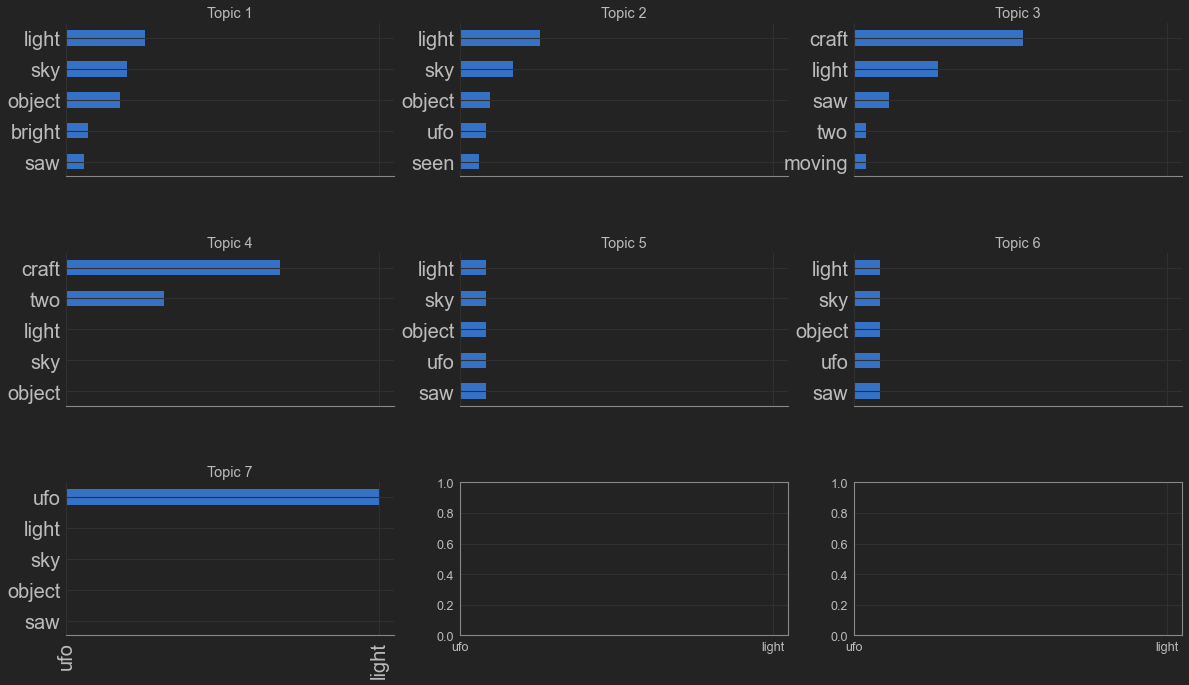

In [115]:
plot_top_words(hdp_model)


In [419]:
# Save data
feature_df = feature_df.drop(columns=['hdp_topic', 'lda_topic'])
feature_df.to_pickle('features_and_topics.pickle')

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
feature_df = pd.read_pickle('features_and_topics.pickle')


grouped = feature_df.groupby(['year', 'topic']).size().reset_index(name='counts')


pivot_df = grouped.pivot(index='year', columns='topic', values='counts')
pivot_df = pivot_df.fillna(0)
pivot_df.plot(kind='bar', stacked=True, figsize=(10,7))

plt.xlabel('Year')
plt.ylabel('Counts')
plt.title('Topic distribution per year')

plt.show()


KeyError: 'year'

In [416]:
from transformers import DistilBertModel, DistilBertTokenizer
import torch
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

GENERATE = False

if GENERATE:
    embeddings = []
    tokens = feature_df['summary'].dropna().apply(tokenizer.tokenize)
    for t in tokens:
        input_ids = torch.tensor([tokenizer.convert_tokens_to_ids(t)])
        with torch.no_grad():
            last_hidden_states = model(input_ids)[0]
        embedding = last_hidden_states[0][0].numpy()
        embeddings.append(embedding)
        embeddings_arr = np.vstack(embeddings)
        pd.Series(embeddings, index=feature_df.summary.dropna().index).to_pickle('embeddings.pickle')
else:
    embeddings = pd.read_pickle('embeddings.pickle')
    embeddings.name = 'bert_embs'


In [ ]:
delta_means = compute_delta_means(cluster_means)

KeyError: 'Year'